<a href="https://colab.research.google.com/github/pvhau169/MLTSA22_HPhan/blob/main/HW8/MLTSA2022_GP_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pylab as pl

%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive

drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/UDStuff/MachineLearningForTimeSeries/HW7/
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/UDStuff/MachineLearningForTimeSeries/HW7/"
!chmod 600 kaggle.json

Mounted at /content/gdrive
/content/gdrive/MyDrive/UDStuff/MachineLearningForTimeSeries/HW7


In [140]:
lcvs = pd.read_csv("training_set.csv")
lcvs.shape

(1421705, 6)

In [4]:
lcvs.head() 

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [5]:
print("The shape of light curves dataset is:", lcvs.shape)

The shape of light curves dataset is: (1421705, 6)


In [6]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

Passbands (filter) identifiers: [2 1 3 4 5 0]
There are 7848 astrophysical simulated objects in my dataset


In [28]:
group_data = group_data = lcvs.groupby(["object_id", "passband"])
group_data.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59580.0343,2,-544.810303,3.622952,1
1,615,59580.0347,1,-816.434326,5.553370,1
2,615,59580.0347,3,-471.385529,3.801213,1
3,615,59580.0347,4,-388.984985,11.395031,1
4,615,59580.0347,2,-681.858887,4.041204,1
...,...,...,...,...,...,...
1421623,130779836,60674.3475,1,848.485596,24.222153,1
1421624,130779836,60674.3475,3,1475.042236,30.874821,1
1421632,130779836,60674.3486,0,129.561722,54.132854,0
1421633,130779836,60674.3526,1,441.659821,21.284473,1


In [37]:
len(lcvs['mjd'].unique())

282504

In [46]:
temp = []
for i in lcvs['passband'].unique():
  time_per_band = lcvs[lcvs['passband'] == i]['mjd'].unique()
  print("passband {} has {} unique timestamps with min {} and max {}".format(i, len(time_per_band), time_per_band.min(), time_per_band.max()))
  temp.append(len(time_per_band))

print(np.array(temp).sum())

passband 2 has 105098 unique timestamps with min 59580.0343 and max 60674.3585
passband 1 has 86083 unique timestamps with min 59580.0347 and max 60674.3625
passband 3 has 105178 unique timestamps with min 59580.0347 and max 60674.3612
passband 4 has 115853 unique timestamps with min 59580.0347 and max 60674.3625
passband 5 has 119739 unique timestamps with min 59580.0352 and max 60674.3625
passband 0 has 66971 unique timestamps with min 59580.0419 and max 60674.363
598922


In this homework, I want to treat flux timeseries of every passband separately. I dont want to flatten all 6 timeseries to feed into autoencoder. I think it will be better for model to classify the object if I stack 6 timeseries with same timestamp, each timestamp has 6 features which is flux value across 6 passband.

Fortunately, all 6 timeseries has the same min,max timestamp and around 100000 unique timestamps. The new interpolated timeseries will have 1000 timestamps spread evenly from 0 to 1094 (originally 59580 to 60674)

In [47]:
from scipy import interpolate

1094

In [67]:
lcvs['object_id'].unique()

array([      615,       713,       730, ..., 130762946, 130772921,
       130779836])

In [176]:
from tqdm.notebook import tqdm
min_time_stamp = 59580
max_time_stamp = 60674

time = np.linspace(0,max_time_stamp-min_time_stamp, num = 50)

obj_ids = lcvs['object_id'].unique()
passbands = range(6)
data = []
for obj_id in tqdm(obj_ids):
  obj_data = []
  for passband in passbands:
    mask = (lcvs['object_id'] == obj_id) & (lcvs['passband'] == passband)

    y = lcvs['flux'][mask]
    x = lcvs['mjd'][mask]

    interpolate_flux = interpolate.interp1d(x = x-min_time_stamp, y = y, fill_value="extrapolate")
    interpolated = interpolate_flux(time)
    obj_data.append(interpolated)

  data.append(obj_data)
data = np.array(data)

  0%|          | 0/7848 [00:00<?, ?it/s]

In [177]:
data.shape

(7848, 6, 50)

the Interpolated data has 7848 objects, each has 6 flux timeseries accross 6 passbands

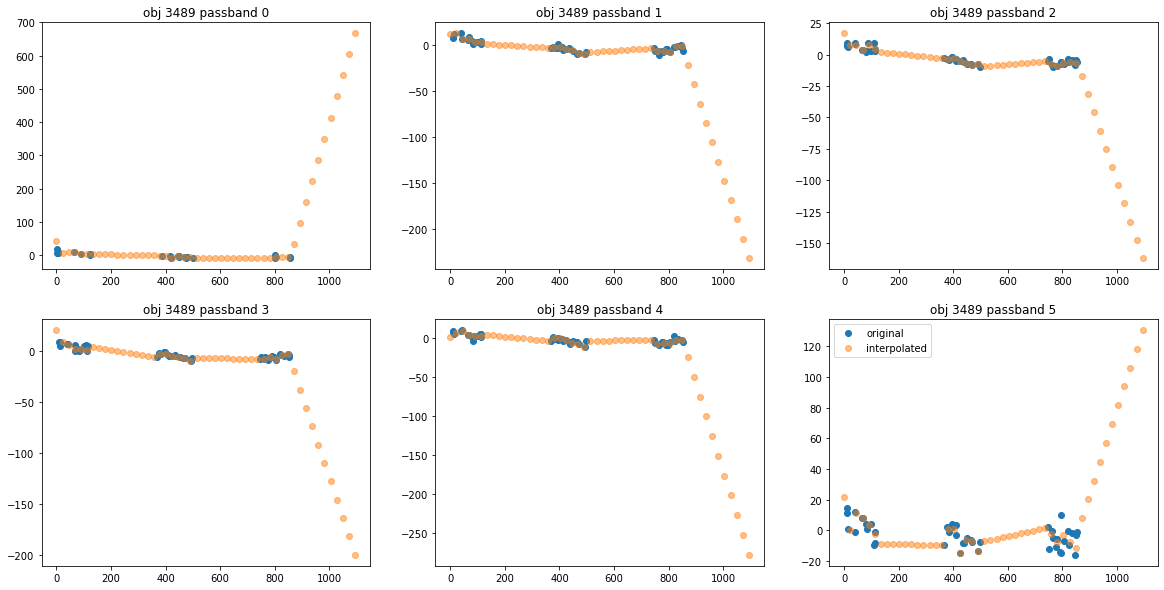

In [184]:
fig = plt.figure(figsize = (20, 10))
axes = []
obj_index = 20
obj_id = obj_ids[obj_index]

for passband in range(6):
  axes.append(fig.add_subplot(2, 3, passband+1))

  mask = (lcvs['object_id'] == obj_id) & (lcvs['passband'] == passband)

  y = lcvs['flux'][mask]
  x = lcvs['mjd'][mask]
  axes[-1].scatter(x-min_time_stamp, y, label='original')
  axes[-1].scatter(time, data[obj_index][passband], label = 'interpolated', alpha = 0.5)
  axes[-1].set_title("obj {} passband {}".format(obj_id, passband))
plt.legend()

An example of interpolated data of obj 3489

In the future, I think feeding the whole timeseries into model is an bad idead since the interpolated data after timestamp 800 are meaningless. I will make another binary timeseries which tell if the value at that timestamp is in recorded range or not. For example from 0 to 800 it has value of 1, otherwise 0

In [185]:
np.save('process_dawta.numpy', arr = data)